# CMIP6 without the interpolation: Grid-native analysis with Pangeo in the cloud
*Julius Busecke*<sup>1</sup> and *Ryan Abernathey*<sup>2</sup>

(<sup>1</sup> Princeton University  <sup>2</sup> Columbia University)

The coupled model intercomparison project (CMIP; currently in its [6th iteration](https://www.geosci-model-dev.net/9/1937/2016/)) involves contribution from countries around the world, constituting a combined dataset of of 20+ Petabytes.

Many years of planning go into the inception of the different scenarios, various model intercomparison projects (MIPs) and the delivery of the output data from the modeling community around the globe. A major challenge for the earth science community now, is to effectively analyze this dataset and answer science question that improve our understanding of the earth system for the coming years.

The Pangeo project recently introduced large parts of the CMIP6 data archive into the [cloud](https://medium.com/pangeo/cmip6-in-the-cloud-five-ways-96b177abe396). This enables, for the first time, centralized, reproducible science of state-of-the-art climate simulations without the need to own large storage or a supercomputer as a user.

The data itself however, still presents significant challenges for analysis, one of which is applying operations across many models. Two of the major hurdles are different naming/metadata between modeling centers and complex grid layouts, particularly for the ocean components of climate models. Common workflows in the past often included interpolating/remapping desired variables and creating new files, creating organizational burden, and increasing storage requirements.

We will demonstrate two pangeo tools which enable seamless calculation of common operations like vector calculus operators (grad, curl, div) and weighted averages/integrals across a wide range of CMIP6 models directly on the data stored in the cloud. `cmip6_preprocessing` provides numerous tools to unify naming conventions and reconstruct grid information and metrics (like distances). This information is used by `xgcm` to enable finite volume analysis on the native model grids. The combination of both tools facilitates fast analysis while ensuring a reproducible and accurate workflow.

In [1]:
from dask.distributed import Client, progress
from dask_gateway import Gateway

gateway = Gateway()
cluster = gateway.new_cluster()
cluster.scale(60)
cluster

In [2]:
client = Client(cluster)
client

Client Scheduler: gateway://traefik-ocean-prod-dask-gateway.ocean-prod:80/ocean-prod.b8379c8640314c0ea8614c0921483fab Dashboard: https://ocean.pangeo.io/services/dask-gateway/clusters/ocean-prod.b8379c8640314c0ea8614c0921483fab/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


# Loading the CMIP6 data from the cloud

In order to load the cmip data from the cloud storage, we use `intake-esm`, and choose to load all monthly ocean model output (`table_id='Omon'`) of sea surface temperature (`variable_id='tos'`) on the native grid (`grid_label='gn'`) and for the 'historical' run (`experiment_id='historical'`). 
For more details on how to use intake-esm we refer to this [Earth Cube presentation]( https://github.com/andersy005/intake-pangeo-catalog-EarthCube-2020). 

In [3]:
import intake
import warnings
warnings.filterwarnings("ignore")

url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)
models = col.df['source_id'].unique()
# we will have to eliminate some models that do not *yet* play nice with cmip6_preprocessing
# ignore_models = ['FGOALS-f3-L','EC-Earth3','EC-Earth3-Veg-LR', 'CESM2-FV2',
#                  'GFDL-ESM4', 'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-LR', 'NorCPM1',
#                  'GISS-E2-1-H', 'IPSL-CM6A-LR', 'MRI-ESM2-0', 'CESM2-WACCM',
#                  'GISS-E2-1-G', 'FIO-ESM-2-0', 'MCM-UA-1-0', 'FGOALS-g3']
# models = [m for m in models if 'AWI' not in m and m not in ignore_models]

# These might change in the future so it is better to explicitly allow the models that work

models = ['TaiESM1','BCC-ESM1','CNRM-ESM2-1','MIROC6','UKESM1-0-LL','NorESM2-LM',
          'BCC-CSM2-MR','CanESM5','ACCESS-ESM1-5','E3SM-1-1-ECA','E3SM-1-1',
          'MIROC-ES2L','CESM2','CNRM-CM6-1','GFDL-CM4','CAMS-CSM1-0','CAS-ESM2-0',
          'CanESM5-CanOE','IITM-ESM','CNRM-CM6-1-HR','ACCESS-CM2','E3SM-1-0',
          'EC-Earth3-LR','EC-Earth3-Veg','INM-CM4-8','INM-CM5-0','HadGEM3-GC31-LL',
          'HadGEM3-GC31-MM','MPI-ESM1-2-HR','GISS-E2-1-G-CC','GISS-E2-2-G','CESM2-WACCM-FV2',
          'NorESM1-F','NorESM2-MM','KACE-1-0-G','GFDL-AM4','NESM3',
          'SAM0-UNICON','CIESM','CESM1-1-CAM5-CMIP5','CMCC-CM2-HR4','CMCC-CM2-VHR4',
          'EC-Earth3P-HR','EC-Earth3P','ECMWF-IFS-HR','ECMWF-IFS-LR','INM-CM5-H',
          'IPSL-CM6A-ATM-HR','HadGEM3-GC31-HM','HadGEM3-GC31-LM','MPI-ESM1-2-XR','MRI-AGCM3-2-H',
          'MRI-AGCM3-2-S','GFDL-CM4C192','GFDL-OM4p5B']

cat = col.search(table_id='Omon', grid_label='gn', experiment_id='historical', variable_id='tos', source_id=models)

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:138: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


We have to eliminate some models from this analysis: The `AWI` models, due to their unstructured native grid, as well as others for various subtleties that have yet to be resolved. This will be addressed in a future update of `cmip6_preprocessing`. If you do not see your favorite model, please consider raising an issue on [github](https://github.com/jbusecke/cmip6_preprocessing/issues).

In [4]:
cat.df['source_id'].nunique() # This represents the number of models as of 6/14/2020.
                              # More models might be added in the future. See commented parts in previous code cell.

27

This gives us 27 different models ('source_ids') to work with. Lets load them into a dictionary and inspect them closer.

In [5]:
# Fix described here: https://github.com/intake/filesystem_spec/issues/317
# Would cause `Name (gs) already in the registry and clobber is False` error somewhere in `intake-esm`
import fsspec
fsspec.filesystem('gs')

ddict = cat.to_dataset_dict(zarr_kwargs={'consolidated':True, 'decode_times':False})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


What we ultimately want is to apply an analysis or just a visualization across all these models. So before we jump into that, lets inspect a few of the datasets:

In [6]:
ddict['CMIP.NCAR.CESM2.historical.Omon.gn']

<xarray.Dataset>
Dimensions:    (d2: 2, member_id: 11, nlat: 384, nlon: 320, time: 3960, vertices: 4)
Coordinates:
    lon        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    time_bnds  (time, d2) float64 dask.array<chunksize=(3960, 2), meta=np.ndarray>
    lon_bnds   (nlat, nlon, vertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lat        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lat_bnds   (nlat, nlon, vertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
  * time       (time) float64 0.0 707.0 1.415e+03 ... 1.444e+06 1.445e+06
  * nlat       (nlat) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
  * nlon       (nlon) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * member_id  (member_id) <U9 'r10i1p1f1' 'r11i1p1f1' ... 'r8i1p1f1' 'r9i1p1f1'
Dimensions without coordinates: d2, vertices
Data variables:
    tos        (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 400, 384, 320), meta=np.ndarray>
Attributes:
    institution:             National Center for Atmospheric Research, Climat...
    history:                 \n2019-08-02 08:55:11.664415 xarray.merge(<ALL_V...
    nominal_resolution:      100 km
    variable_id:             tos
    cesm_casename:           b.e21.BHIST.f09_g17.CMIP6-historical.009
    activity_id:             CMIP
    variant_label:           r9i1p1f1
    parent_variant_label:    r1i1p1f1
    initialization_index:    1
    status:                  2019-10-25;created;by nhn2@columbia.edu
    product:                 model-output
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    source_type:             AOGCM BGC
    tracking_id:             hdl:21.14100/5ac93391-d2b6-410a-8c32-27ac884c2d8...
    source:                  CESM2 (2017): atmosphere: CAM6 (0.9x1.25 finite ...
    experiment_id:           historical
    forcing_index:           1
    parent_activity_id:      CMIP
    parent_mip_era:          CMIP6
    parent_experiment_id:    piControl
    sub_experiment:          none
    branch_time_in_child:    674885.0
    grid:                    native gx1v7 displaced pole grid (384x320 latxlon)
    mip_era:                 CMIP6
    case_id:                 23
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.NCAR.CESM2....
    intake_esm_varname:      tos
    table_id:                Omon
    parent_source_id:        CESM2
    realization_index:       9
    variant_info:            CMIP6 20th century experiments (1850-2014) with ...
    license:                 CMIP6 model data produced by <The National Cente...
    experiment:              all-forcing simulation of the recent past
    grid_label:              gn
    contact:                 cesm_cmip6@ucar.edu
    external_variables:      areacello
    institution_id:          NCAR
    branch_method:           standard
    source_id:               CESM2
    parent_time_units:       days since 0001-01-01 00:00:00
    Conventions:             CF-1.7 CMIP-6.2
    branch_time_in_parent:   295650.0
    data_specs_version:      01.00.29
    realm:                   ocean
    sub_experiment_id:       none
    frequency:               mon
    physics_index:           1
    intake_esm_dataset_key:  CMIP.NCAR.CESM2.historical.Omon.gn

In [7]:
ddict['CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.Omon.gn']

<xarray.Dataset>
Dimensions:      (axis_nbounds: 2, member_id: 30, nvertex: 4, time: 3959, x: 362, y: 294)
Coordinates:
    bounds_lat   (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    lon          (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    time_bounds  (time, axis_nbounds) float64 dask.array<chunksize=(3959, 2), meta=np.ndarray>
    lat          (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    bounds_lon   (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
  * time         (time) float64 0.0 15.5 45.0 ... 1.444e+06 1.445e+06 1.446e+06
  * member_id    (member_id) <U9 'r10i1p1f2' 'r11i1p1f2' ... 'r9i1p1f2'
Dimensions without coordinates: axis_nbounds, nvertex, x, y
Data variables:
    tos          (member_id, time, y, x) float32 dask.array<chunksize=(1, 126, 294, 362), meta=np.ndarray>
Attributes:
    arpege_minor_version:    6.3.2
    institution:             CNRM (Centre National de Recherches Meteorologiq...
    history:                 none\nMon Jul 30 13:06:24 2018: ncatted -O -a tr...
    nominal_resolution:      100 km
    variable_id:             tos
    activity_id:             CMIP
    parent_variant_label:    r1i1p1f2
    initialization_index:    1
    status:                  2019-11-11;created;by nhn2@columbia.edu
    product:                 model-output
    references:              http://www.umr-cnrm.fr/cmip6/references
    source_type:             AOGCM
    dr2xml_md5sum:           92ddb3d0d8ce79f498d792fc8e559dcf
    tracking_id:             hdl:21.14100/815bde79-bb52-48db-8104-8d4d52df5d0...
    source:                  CNRM-CM6-1 (2017):  aerosol: prescribed monthly ...
    experiment_id:           historical
    forcing_index:           2
    parent_activity_id:      CMIP
    parent_mip_era:          CMIP6
    nemo_gelato_commit:      49095b3accd5d4c_6524fe19b00467a
    parent_experiment_id:    piControl
    sub_experiment:          none
    branch_time_in_child:    0.0
    grid:                    native ocean tri-polar grid with 105 k ocean cells
    mip_era:                 CMIP6
    xios_commit:             1442-shuffle
    name:                    /scratch/work/voldoire/outputs/CMIP6/DECK/CNRM-C...
    intake_esm_varname:      tos
    table_id:                Omon
    parent_source_id:        CNRM-CM6-1
    NCO:                     "4.5.5"
    license:                 CMIP6 model data produced by CNRM-CERFACS is lic...
    experiment:              all-forcing simulation of the recent past
    title:                   CNRM-CM6-1 model output prepared for CMIP6 / CMI...
    grid_label:              gn
    contact:                 contact.cmip@meteo.fr
    external_variables:      areacello
    institution_id:          CNRM-CERFACS
    branch_method:           standard
    source_id:               CNRM-CM6-1
    parent_time_units:       days since 1850-01-01 00:00:00
    dr2xml_version:          1.13
    Conventions:             CF-1.7 CMIP-6.2
    CMIP6_CV_version:        cv=6.2.3.0-7-g2019642
    data_specs_version:      01.00.21
    realm:                   ocean
    sub_experiment_id:       none
    description:             CMIP6 historical
    frequency:               mon
    physics_index:           1
    intake_esm_dataset_key:  CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.Omon.gn

In [8]:
ddict['CMIP.CSIRO.ACCESS-ESM1-5.historical.Omon.gn']

<xarray.Dataset>
Dimensions:             (bnds: 2, i: 360, j: 300, member_id: 3, time: 1980, vertices: 4)
Coordinates:
    time_bnds           (time, bnds) float64 dask.array<chunksize=(1980, 2), meta=np.ndarray>
    latitude            (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
  * time                (time) int64 0 708 1416 2148 ... 1444152 1444884 1445616
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 293 294 295 296 297 298 299
  * member_id           (member_id) <U8 'r1i1p1f1' 'r2i1p1f1' 'r3i1p1f1'
Dimensions without coordinates: bnds, vertices
Data variables:
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(300, 360, 4), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(300, 360, 4), meta=np.ndarray>
    tos                 (member_id, time, j, i) float32 dask.array<chunksize=(1, 201, 300, 360), meta=np.ndarray>
Attributes:
    institution:             Commonwealth Scientific and Industrial Research ...
    history:                 2019-11-15T15:21:42Z ; CMOR rewrote data to be c...
    nominal_resolution:      250 km
    variable_id:             tos
    cmor_version:            3.4.0
    activity_id:             CMIP
    variant_label:           r3i1p1f1
    parent_variant_label:    r1i1p1f1
    initialization_index:    1
    table_info:              Creation Date:(30 April 2019) MD5:e14f55f257ccea...
    status:                  2020-05-09;created; by gcs.cmip6.ldeo@gmail.com
    product:                 model-output
    source_type:             AOGCM
    creation_date:           2019-12-03T10:07:56Z
    tracking_id:             hdl:21.14100/02850fcc-be64-40de-b7ca-9b8aa6e688a...
    source:                  ACCESS-ESM1.5 (2019): \naerosol: CLASSIC (v1.0)\...
    experiment_id:           historical
    forcing_index:           1
    parent_activity_id:      CMIP
    parent_mip_era:          CMIP6
    parent_experiment_id:    piControl
    sub_experiment:          none
    branch_time_in_child:    0.0
    grid:                    native atmosphere N96 grid (145x192 latxlon)
    mip_era:                 CMIP6
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.CSIRO.ACCES...
    intake_esm_varname:      tos
    version:                 v20191203
    table_id:                Omon
    parent_source_id:        ACCESS-ESM1-5
    notes:                   Exp: ESM-historical; Local ID: HI-07; Variable: ...
    realization_index:       3
    license:                 CMIP6 model data produced by CSIRO is licensed u...
    experiment:              all-forcing simulation of the recent past
    title:                   ACCESS-ESM1-5 output prepared for CMIP6
    grid_label:              gn
    external_variables:      areacello
    institution_id:          CSIRO
    branch_method:           standard
    source_id:               ACCESS-ESM1-5
    parent_time_units:       days since 0101-1-1
    Conventions:             CF-1.7 CMIP-6.2
    branch_time_in_parent:   36524.0
    data_specs_version:      01.00.30
    realm:                   ocean
    sub_experiment_id:       none
    frequency:               mon
    physics_index:           1
    run_variant:             forcing: GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2...
    intake_esm_dataset_key:  CMIP.CSIRO.ACCESS-ESM1-5.historical.Omon.gn

We can immediately spot problems:

- There is no consistent convention for the labeling of dimensions (note the 'logical 1D dimension in the x-direction is called `x`, `nlon`, `i`)

- Some models (here: `CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.Omon.gn`) are missing the 'vertex'/'vertices' dimension, due to the fact that the cell geometry is given by longitude and latitude 'bounds' centered on the cell face compared to the corners of the cell.

There are more issues that both make working with the data cumbersome and can quickly introduce errors. For instance, some models give depth in units of cm, not m, and many other issues. Instead of focusing on problems, here we would like to illustrate how easy analysis across models with different grids can be, using `cmip6_preprocessing`.

## Use `cmip6_preprocessing` to harmonize different model output 

[`cmip6_preprocessing`](https://github.com/jbusecke/cmip6_preprocessing) was born out of the [cmip6-hackathon](https://cmip6hack.github.io/#/) and aims to provide a central package through which these conventions can be harmonized. For convenience we will make use of the `preprocess` functionality and apply the 'catch-all' function `combined_preprocessing` to the data before it gets aggregated. For a more detailed description of the corrections applied we refer to the [documentation and examples therein](https://github.com/jbusecke/cmip6_preprocessing/blob/master/doc/tutorial.ipynb).

In [9]:
from cmip6_preprocessing.preprocessing import combined_preprocessing

ddict_pp = cat.to_dataset_dict(
    zarr_kwargs={'consolidated':True, 'decode_times':False},
    preprocess=combined_preprocessing
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


> Note that all functions in the `cmip6_preprocessing.preprocessing` modules can also be used with 'raw' datasets, like e.g. a local netcdf file, as long as the metadata is intact.

Now lets look at the preprocessed version of the same datasets from above:

In [10]:
ddict_pp['CMIP.NCAR.CESM2.historical.Omon.gn']

<xarray.Dataset>
Dimensions:        (bnds: 2, member_id: 11, time: 3960, vertex: 4, x: 320, y: 384)
Coordinates:
    lon            (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lat_verticies  (y, x, vertex) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    time_bounds    (time, bnds) float64 dask.array<chunksize=(3960, 2), meta=np.ndarray>
    lat            (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    lon_bounds     (bnds, y, x) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
  * time           (time) float64 0.0 707.0 1.415e+03 ... 1.444e+06 1.445e+06
  * vertex         (vertex) int64 0 1 2 3
  * bnds           (bnds) int64 0 1
  * x              (x) float64 1.062 2.187 3.312 4.437 ... 357.7 358.8 359.9
  * y              (y) float64 -79.22 -78.69 -78.15 -77.62 ... 89.11 89.66 89.71
  * member_id      (member_id) <U9 'r10i1p1f1' 'r11i1p1f1' ... 'r9i1p1f1'
Data variables:
    tos            (member_id, time, y, x) float32 dask.array<chunksize=(1, 400, 384, 320), meta=np.ndarray>
Attributes:
    institution:             National Center for Atmospheric Research, Climat...
    history:                 \n2019-08-02 08:55:11.664415 xarray.merge(<ALL_V...
    nominal_resolution:      100 km
    variable_id:             tos
    cesm_casename:           b.e21.BHIST.f09_g17.CMIP6-historical.009
    activity_id:             CMIP
    variant_label:           r9i1p1f1
    parent_variant_label:    r1i1p1f1
    initialization_index:    1
    status:                  2019-10-25;created;by nhn2@columbia.edu
    product:                 model-output
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    source_type:             AOGCM BGC
    tracking_id:             hdl:21.14100/5ac93391-d2b6-410a-8c32-27ac884c2d8...
    source:                  CESM2 (2017): atmosphere: CAM6 (0.9x1.25 finite ...
    experiment_id:           historical
    forcing_index:           1
    parent_activity_id:      CMIP
    parent_mip_era:          CMIP6
    parent_experiment_id:    piControl
    sub_experiment:          none
    branch_time_in_child:    674885.0
    grid:                    native gx1v7 displaced pole grid (384x320 latxlon)
    mip_era:                 CMIP6
    case_id:                 23
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.NCAR.CESM2....
    intake_esm_varname:      tos
    table_id:                Omon
    parent_source_id:        CESM2
    realization_index:       9
    variant_info:            CMIP6 20th century experiments (1850-2014) with ...
    license:                 CMIP6 model data produced by <The National Cente...
    experiment:              all-forcing simulation of the recent past
    grid_label:              gn
    contact:                 cesm_cmip6@ucar.edu
    external_variables:      areacello
    institution_id:          NCAR
    branch_method:           standard
    source_id:               CESM2
    parent_time_units:       days since 0001-01-01 00:00:00
    Conventions:             CF-1.7 CMIP-6.2
    branch_time_in_parent:   295650.0
    data_specs_version:      01.00.29
    realm:                   ocean
    sub_experiment_id:       none
    frequency:               mon
    physics_index:           1
    intake_esm_dataset_key:  CMIP.NCAR.CESM2.historical.Omon.gn

In [11]:
ddict_pp['CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.Omon.gn']

<xarray.Dataset>
Dimensions:        (bnds: 2, member_id: 30, time: 3959, vertex: 4, x: 362, y: 294)
Coordinates:
    lon            (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    lat_verticies  (y, x, vertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    time_bounds    (time, bnds) float64 dask.array<chunksize=(3959, 2), meta=np.ndarray>
    lat            (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 294, 362), meta=np.ndarray>
    lon_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 294, 362), meta=np.ndarray>
  * time           (time) float64 0.0 15.5 45.0 ... 1.445e+06 1.446e+06
  * vertex         (vertex) int64 0 1 2 3
  * bnds           (bnds) int64 0 1
  * x              (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * y              (y) float64 -78.36 -78.17 -77.98 -77.79 ... 89.37 89.74 90.0
  * member_id      (member_id) <U9 'r10i1p1f2' 'r11i1p1f2' ... 'r9i1p1f2'
Data variables:
    tos            (member_id, time, y, x) float32 dask.array<chunksize=(1, 126, 294, 362), meta=np.ndarray>
Attributes:
    arpege_minor_version:    6.3.2
    institution:             CNRM (Centre National de Recherches Meteorologiq...
    history:                 none\nMon Jul 30 13:06:24 2018: ncatted -O -a tr...
    nominal_resolution:      100 km
    variable_id:             tos
    activity_id:             CMIP
    parent_variant_label:    r1i1p1f2
    initialization_index:    1
    status:                  2019-11-11;created;by nhn2@columbia.edu
    product:                 model-output
    references:              http://www.umr-cnrm.fr/cmip6/references
    source_type:             AOGCM
    dr2xml_md5sum:           92ddb3d0d8ce79f498d792fc8e559dcf
    tracking_id:             hdl:21.14100/815bde79-bb52-48db-8104-8d4d52df5d0...
    source:                  CNRM-CM6-1 (2017):  aerosol: prescribed monthly ...
    experiment_id:           historical
    forcing_index:           2
    parent_activity_id:      CMIP
    parent_mip_era:          CMIP6
    nemo_gelato_commit:      49095b3accd5d4c_6524fe19b00467a
    parent_experiment_id:    piControl
    sub_experiment:          none
    branch_time_in_child:    0.0
    grid:                    native ocean tri-polar grid with 105 k ocean cells
    mip_era:                 CMIP6
    xios_commit:             1442-shuffle
    name:                    /scratch/work/voldoire/outputs/CMIP6/DECK/CNRM-C...
    intake_esm_varname:      tos
    table_id:                Omon
    parent_source_id:        CNRM-CM6-1
    NCO:                     "4.5.5"
    license:                 CMIP6 model data produced by CNRM-CERFACS is lic...
    experiment:              all-forcing simulation of the recent past
    title:                   CNRM-CM6-1 model output prepared for CMIP6 / CMI...
    grid_label:              gn
    contact:                 contact.cmip@meteo.fr
    external_variables:      areacello
    institution_id:          CNRM-CERFACS
    branch_method:           standard
    source_id:               CNRM-CM6-1
    parent_time_units:       days since 1850-01-01 00:00:00
    dr2xml_version:          1.13
    Conventions:             CF-1.7 CMIP-6.2
    CMIP6_CV_version:        cv=6.2.3.0-7-g2019642
    data_specs_version:      01.00.21
    realm:                   ocean
    sub_experiment_id:       none
    description:             CMIP6 historical
    frequency:               mon
    physics_index:           1
    intake_esm_dataset_key:  CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.Omon.gn

In [12]:
ddict_pp['CMIP.CSIRO.ACCESS-ESM1-5.historical.Omon.gn']

<xarray.Dataset>
Dimensions:        (bnds: 2, member_id: 3, time: 1980, vertex: 4, x: 360, y: 300)
Coordinates:
    lon            (y, x) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
    lat_verticies  (y, x, vertex) float64 dask.array<chunksize=(300, 360, 4), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float64 dask.array<chunksize=(300, 360, 4), meta=np.ndarray>
    time_bounds    (time, bnds) float64 dask.array<chunksize=(1980, 2), meta=np.ndarray>
    lat            (y, x) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    lon_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
  * time           (time) int64 0 708 1416 2148 ... 1444152 1444884 1445616
  * vertex         (vertex) int64 0 1 2 3
  * bnds           (bnds) int64 0 1
  * x              (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * y              (y) float64 -77.88 -77.63 -77.38 -77.13 ... 88.87 89.31 89.75
  * member_id      (member_id) <U8 'r1i1p1f1' 'r2i1p1f1' 'r3i1p1f1'
Data variables:
    tos            (member_id, time, y, x) float32 dask.array<chunksize=(1, 201, 300, 360), meta=np.ndarray>
Attributes:
    institution:             Commonwealth Scientific and Industrial Research ...
    history:                 2019-11-15T15:21:42Z ; CMOR rewrote data to be c...
    nominal_resolution:      250 km
    variable_id:             tos
    cmor_version:            3.4.0
    activity_id:             CMIP
    variant_label:           r3i1p1f1
    parent_variant_label:    r1i1p1f1
    initialization_index:    1
    table_info:              Creation Date:(30 April 2019) MD5:e14f55f257ccea...
    status:                  2020-05-09;created; by gcs.cmip6.ldeo@gmail.com
    product:                 model-output
    source_type:             AOGCM
    creation_date:           2019-12-03T10:07:56Z
    tracking_id:             hdl:21.14100/02850fcc-be64-40de-b7ca-9b8aa6e688a...
    source:                  ACCESS-ESM1.5 (2019): \naerosol: CLASSIC (v1.0)\...
    experiment_id:           historical
    forcing_index:           1
    parent_activity_id:      CMIP
    parent_mip_era:          CMIP6
    parent_experiment_id:    piControl
    sub_experiment:          none
    branch_time_in_child:    0.0
    grid:                    native atmosphere N96 grid (145x192 latxlon)
    mip_era:                 CMIP6
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.CSIRO.ACCES...
    intake_esm_varname:      tos
    version:                 v20191203
    table_id:                Omon
    parent_source_id:        ACCESS-ESM1-5
    notes:                   Exp: ESM-historical; Local ID: HI-07; Variable: ...
    realization_index:       3
    license:                 CMIP6 model data produced by CSIRO is licensed u...
    experiment:              all-forcing simulation of the recent past
    title:                   ACCESS-ESM1-5 output prepared for CMIP6
    grid_label:              gn
    external_variables:      areacello
    institution_id:          CSIRO
    branch_method:           standard
    source_id:               ACCESS-ESM1-5
    parent_time_units:       days since 0101-1-1
    Conventions:             CF-1.7 CMIP-6.2
    branch_time_in_parent:   36524.0
    data_specs_version:      01.00.30
    realm:                   ocean
    sub_experiment_id:       none
    frequency:               mon
    physics_index:           1
    run_variant:             forcing: GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2...
    intake_esm_dataset_key:  CMIP.CSIRO.ACCESS-ESM1-5.historical.Omon.gn

Much better! 

As you can see, they all have consistent dimension names and coordinates. Time to see if this works as advertised, by plotting the sea surface temperature (SST) for all models

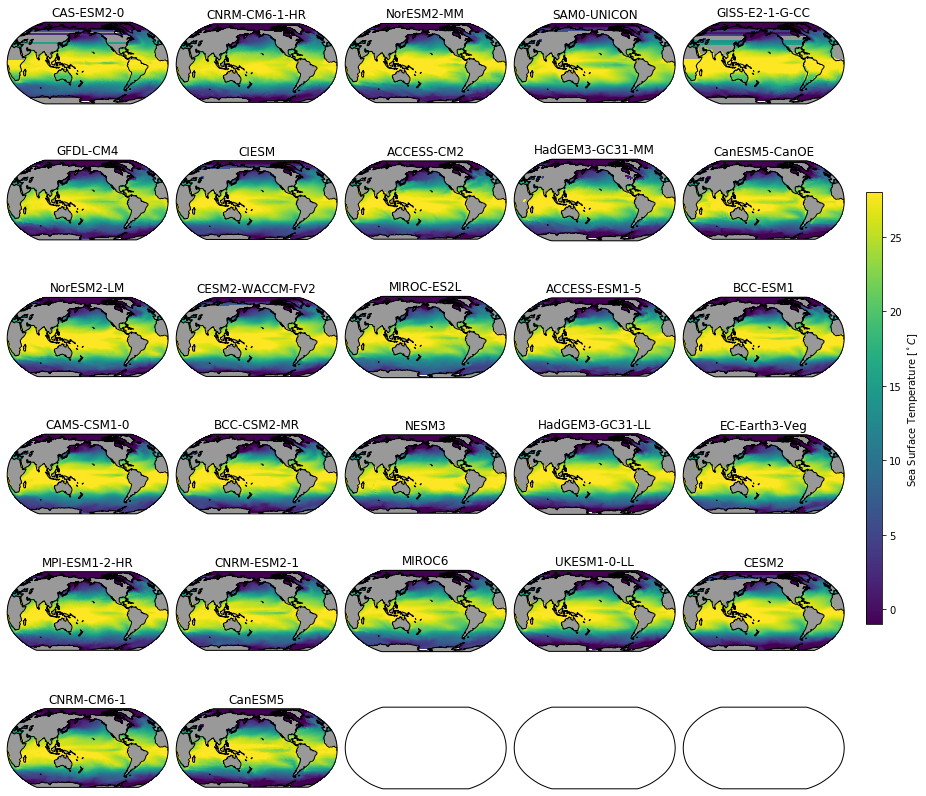

In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, axarr = plt.subplots(
    ncols=5, nrows=6, figsize=[15, 15], subplot_kw={"projection": ccrs.Robinson(190)}
)
for ax, (k, ds) in zip(axarr.flat, ddict_pp.items()):
    # Select a single member for each model
    if 'member_id' in ds.dims:
        ds = ds.isel(member_id=-1)

    # select the first time step
    da = ds.tos.isel(time=0)
    
    # some models have large values instead of nans, so we mask unresonable values
    da = da.where(da < 1e30)
    
    # and plot the resulting 2d array using xarray
    pp = da.plot(
        ax=ax,
        x="lon",
        y="lat",
        vmin=-1,
        vmax=28,
        transform=ccrs.PlateCarree(),
        infer_intervals=False,
        add_colorbar=False,
    )
    
    ax.set_title(ds.attrs['source_id'])
    ax.add_feature(cfeature.LAND, facecolor='0.6')
    ax.coastlines()
fig.subplots_adjust(hspace=0.05, wspace=0.05)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])
fig.colorbar(pp, cax=cbar_ax, label="Sea Surface Temperature [$^\circ C$]")

That was very little code to plot such a comprehensive figure, even if the models all have different resolution and grid architectures.


`cmip6_preprocessing` helps keeping the logic needed for simple analysis and visualization to a minimum, but in the newest version is also helps to facilitate the use of [`xgcm`](https://github.com/xgcm/xgcm) with the native model grids, making it a powerful tool for more complex analysis across the models.

## Calculations on native model grids using `xgcm`.

Most modern circulation models discretize the partial differential equations needed to simulate the earth system on a logically [rectangular grid](https://xgcm.readthedocs.io/en/latest/grids.html). This means the grid for a single time step can be represented as a 3-dimensional array of cells. Operations like e.g., a derivative are then approximated by a finite difference between neighboring cells, divided by the appropriate distance.

Calculating operators like *gradient*, *curl* or *divergence* is usually associated with a lot of bookkeeping to make sure that the difference is taken between the correct grid points, etc. This often leads to users preferring interpolated grids (on regular lon/lat grids), which have to be processed and stored next to the native grid data, both increasing storage requirements and potentially losing some of the detailed structure in the high-resolution model fields.

The combination of `cmip6_preprocessing` and `xgcm` enables the user to quickly calculate operators like *gradient* or *curl* (shown in detail below) on the native model grids, preserving the maximum detail the models provide and preventing unnecessary storage burden. `cmip6_preprocessing` parses the detailed grid information for the different models so that `xgcm` can carry out the computations, without requiring the user to dive into the details of each model grid.

As an example, let us compute and plot the gradient magnitude of the SST.

$ \overline{\nabla(SST)} = \sqrt{\frac{\partial SST}{\partial x}^2 + \frac{\partial SST}{\partial y}^2} $

We will start with an example of just computing the zonal gradient $\frac{\partial SST}{\partial x}$:

First, we need to create a suitable grid, with dimensions both for the cell center (where our tracer is located) and the cell faces. These are needed for xgcm to calculate the finite distance version of the above equation. 

The function `combine_staggered_grid` parses a dataset so that it is compatible with xgcm. It also provides a 'ready-to-use' [xgm Grid object](https://xgcm.readthedocs.io/en/latest/grids.html#creating-grid-objects) for convenience.

In [14]:
# we pick one of the many models
ds = ddict_pp['CMIP.CNRM-CERFACS.CNRM-CM6-1-HR.historical.Omon.gn']
ds

<xarray.Dataset>
Dimensions:        (bnds: 2, member_id: 1, time: 1980, vertex: 4, x: 1442, y: 1050)
Coordinates:
    lon            (y, x) float32 dask.array<chunksize=(1050, 1442), meta=np.ndarray>
    lat_verticies  (y, x, vertex) float32 dask.array<chunksize=(1050, 1442, 4), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float32 dask.array<chunksize=(1050, 1442, 4), meta=np.ndarray>
    time_bounds    (time, bnds) float64 dask.array<chunksize=(1980, 2), meta=np.ndarray>
    lat            (y, x) float32 dask.array<chunksize=(1050, 1442), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float32 dask.array<chunksize=(1, 1050, 1442), meta=np.ndarray>
    lon_bounds     (bnds, y, x) float32 dask.array<chunksize=(1, 1050, 1442), meta=np.ndarray>
  * time           (time) int64 0 708 1416 2148 ... 1444152 1444884 1445616
  * vertex         (vertex) int64 0 1 2 3
  * bnds           (bnds) int64 0 1
  * x              (x) float32 0.25 0.5 0.75 1.0 ... 359.25 359.5 359.75 360.0
  * y              (y) float32 -78.107124 -78.05977 -78.01226 ... 89.94787 90.0
  * member_id      (member_id) <U8 'r1i1p1f2'
Data variables:
    tos            (member_id, time, y, x) float32 dask.array<chunksize=(1, 20, 1050, 1442), meta=np.ndarray>
Attributes:
    CMIP6_CV_version:        cv=6.2.3.0-7-g2019642
    Conventions:             CF-1.7 CMIP-6.2
    EXPID:                   CNRM-CM6-1-HR_historical_r1i1p1f2
    activity_id:             CMIP
    arpege_minor_version:    6.3.3
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   0.0
    contact:                 contact.cmip@meteo.fr
    creation_date:           2019-05-23T13:08:54Z
    data_specs_version:      01.00.21
    description:             CMIP6 historical
    dr2xml_md5sum:           45d4369d889ddfb8149d771d8625e9ec
    dr2xml_version:          1.16
    experiment:              all-forcing simulation of the recent past
    experiment_id:           historical
    external_variables:      areacello
    forcing_index:           2
    frequency:               mon
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.CNRM-CERFAC...
    grid:                    native ocean tri-polar grid with 1.47 M ocean cells
    grid_label:              gn
    history:                 none
    initialization_index:    1
    institution:             CNRM (Centre National de Recherches Meteorologiq...
    institution_id:          CNRM-CERFACS
    license:                 CMIP6 model data produced by CNRM-CERFACS is lic...
    mip_era:                 CMIP6
    nemo_gelato_commit:      84a9e3f161dade7_8250e198106a168
    nominal_resolution:      25 km
    parent_activity_id:      C M I P
    parent_experiment_id:    p i C o n t r o l
    parent_mip_era:          CMIP6
    parent_source_id:        CNRM-CM6-1-HR
    parent_time_units:       days since 1850-01-01 00:00:00
    parent_variant_label:    r1i1p1f2
    physics_index:           1
    product:                 model-output
    realization_index:       1
    realm:                   ocean
    references:              http://www.umr-cnrm.fr/cmip6/references
    source:                  CNRM-CM6-1-HR (2017):  aerosol: prescribed month...
    source_id:               CNRM-CM6-1-HR
    source_type:             AOGCM
    status:                  2020-05-09;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:          none
    sub_experiment_id:       none
    table_id:                Omon
    title:                   CNRM-CM6-1-HR model output prepared for CMIP6 an...
    tracking_id:             hdl:21.14100/ea182917-b175-4bbd-bb83-f127d71fa772
    variable_id:             tos
    variant_label:           r1i1p1f2
    xios_commit:             1442-shuffle
    intake_esm_varname:      tos
    intake_esm_dataset_key:  CMIP.CNRM-CERFACS.CNRM-CM6-1-HR.historical.Omon.gn

In [15]:
from cmip6_preprocessing.grids import combine_staggered_grid

# Now we parse the necessary additional dimensions
grid,ds = combine_staggered_grid(ds)
ds

<xarray.Dataset>
Dimensions:        (bnds: 2, member_id: 1, time: 1980, vertex: 4, x: 1442, x_left: 1442, y: 1050, y_right: 1050)
Coordinates:
    lon            (y, x) float32 dask.array<chunksize=(1050, 1442), meta=np.ndarray>
    lat_verticies  (y, x, vertex) float32 dask.array<chunksize=(1050, 1442, 4), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float32 dask.array<chunksize=(1050, 1442, 4), meta=np.ndarray>
    time_bounds    (time, bnds) float64 dask.array<chunksize=(1980, 2), meta=np.ndarray>
    lat            (y, x) float32 dask.array<chunksize=(1050, 1442), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float32 dask.array<chunksize=(1, 1050, 1442), meta=np.ndarray>
    lon_bounds     (bnds, y, x) float32 dask.array<chunksize=(1, 1050, 1442), meta=np.ndarray>
  * time           (time) int64 0 708 1416 2148 ... 1444152 1444884 1445616
  * vertex         (vertex) int64 0 1 2 3
  * bnds           (bnds) int64 0 1
  * x              (x) float32 0.25 0.5 0.75 1.0 ... 359.25 359.5 359.75 360.0
  * y              (y) float32 -78.107124 -78.05977 -78.01226 ... 89.94787 90.0
  * member_id      (member_id) <U8 'r1i1p1f2'
  * x_left         (x_left) float32 0.125 0.375 0.625 ... 359.625 359.875
  * y_right        (y_right) float32 -78.08345 -78.03601 ... 89.97394 90.02606
Data variables:
    tos            (member_id, time, y, x) float32 dask.array<chunksize=(1, 20, 1050, 1442), meta=np.ndarray>
Attributes:
    CMIP6_CV_version:        cv=6.2.3.0-7-g2019642
    Conventions:             CF-1.7 CMIP-6.2
    EXPID:                   CNRM-CM6-1-HR_historical_r1i1p1f2
    activity_id:             CMIP
    arpege_minor_version:    6.3.3
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   0.0
    contact:                 contact.cmip@meteo.fr
    creation_date:           2019-05-23T13:08:54Z
    data_specs_version:      01.00.21
    description:             CMIP6 historical
    dr2xml_md5sum:           45d4369d889ddfb8149d771d8625e9ec
    dr2xml_version:          1.16
    experiment:              all-forcing simulation of the recent past
    experiment_id:           historical
    external_variables:      areacello
    forcing_index:           2
    frequency:               mon
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.CNRM-CERFAC...
    grid:                    native ocean tri-polar grid with 1.47 M ocean cells
    grid_label:              gn
    history:                 none
    initialization_index:    1
    institution:             CNRM (Centre National de Recherches Meteorologiq...
    institution_id:          CNRM-CERFACS
    license:                 CMIP6 model data produced by CNRM-CERFACS is lic...
    mip_era:                 CMIP6
    nemo_gelato_commit:      84a9e3f161dade7_8250e198106a168
    nominal_resolution:      25 km
    parent_activity_id:      C M I P
    parent_experiment_id:    p i C o n t r o l
    parent_mip_era:          CMIP6
    parent_source_id:        CNRM-CM6-1-HR
    parent_time_units:       days since 1850-01-01 00:00:00
    parent_variant_label:    r1i1p1f2
    physics_index:           1
    product:                 model-output
    realization_index:       1
    realm:                   ocean
    references:              http://www.umr-cnrm.fr/cmip6/references
    source:                  CNRM-CM6-1-HR (2017):  aerosol: prescribed month...
    source_id:               CNRM-CM6-1-HR
    source_type:             AOGCM
    status:                  2020-05-09;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:          none
    sub_experiment_id:       none
    table_id:                Omon
    title:                   CNRM-CM6-1-HR model output prepared for CMIP6 an...
    tracking_id:             hdl:21.14100/ea182917-b175-4bbd-bb83-f127d71fa772
    variable_id:             tos
    variant_label:           r1i1p1f2
    xios_commit:             1442-shuffle
    intake_esm_varname:      tos
    intake_esm_dataset_key:  

Note how the new dimensions `x_left` and `y_right` are added, which are associated with the 'eastern' and 'northern' cell faces. 
We can now easily calculate the finite difference in the logical `X` direction:

In [16]:
delta_t_x = grid.diff(ds.tos, 'X')
delta_t_x

,Array,Chunk
Bytes,11.99 GB,121.04 MB
Shape,"(1, 1980, 1050, 1442)","(1, 20, 1050, 1441)"
Count,1486 Tasks,198 Chunks
Type,float32,numpy.ndarray


This array is now located on the center of the eastern cell face. But in order to recreate a derivative, we need to divide this difference by an appropriate distance. Usually these distances are provided with model output, but currently there is no such data publicly available for CMIP models. 

To solve this problem, `cmip6_preprocessing` can recalculate grid distances.
> Be aware that this can lead to rather large biases when the grid is strongly warped, usually around the Arctic. More on that at the end of the notebook.

In [17]:
grid, ds = combine_staggered_grid(ds, recalculate_metrics=True)

In [18]:
ds

<xarray.Dataset>
Dimensions:        (bnds: 2, member_id: 1, time: 1980, vertex: 4, x: 1442, x_left: 1442, y: 1050, y_right: 1050)
Coordinates:
    lon            (y, x) float32 1.4255313 1.672195 ... 73.60567 73.59864
    lat_verticies  (y, x, vertex) float32 -78.02738 -78.02738 ... 80.10339
    lon_verticies  (y, x, vertex) float32 1.4255313 1.4255313 ... 73.29744
    time_bounds    (bnds, time) float64 dask.array<chunksize=(2, 1980), meta=np.ndarray>
    lat            (y, x) float32 -78.02738 -78.02127 ... 80.2718 80.15926
    lat_bounds     (y, x, bnds) float32 dask.array<chunksize=(1050, 1442, 1), meta=np.ndarray>
    lon_bounds     (y, x, bnds) float32 dask.array<chunksize=(1050, 1442, 1), meta=np.ndarray>
  * time           (time) int64 0 708 1416 2148 ... 1444152 1444884 1445616
  * vertex         (vertex) int64 0 1 2 3
  * bnds           (bnds) int64 0 1
  * x              (x) float32 0.25 0.5 0.75 1.0 ... 359.25 359.5 359.75 360.0
  * y              (y) float32 -78.107124 -78.05977 -78.01226 ... 89.94787 90.0
  * member_id      (member_id) <U8 'r1i1p1f2'
  * x_left         (x_left) float32 0.125 0.375 0.625 ... 359.625 359.875
  * y_right        (y_right) float32 -78.08345 -78.03601 ... 89.97394 90.02606
    dx_t           (y, x) float32 0.0 0.0 0.0 ... 12525.213 12526.91 12527.76
    dy_t           (y, x) float32 0.0 0.0 0.0 ... 11416.201 11413.054 11409.701
    dx_gy          (y_right, x) float32 0.0 0.0 0.0 ... 12526.062 12527.76
    dy_gx          (y, x_left) float32 0.0 0.0 0.0 ... 11414.309 11411.036
    dx_gx          (y, x_left) float32 5695.537 5695.9785 ... 12526.91 12526.91
    dy_gy          (y_right, x) float32 0.0 0.0 0.0 ... 18432876.0 18439940.0
    dx_gxgy        (y_right, x_left) float32 5695.537 5695.9785 ... 12526.91
    dy_gxgy        (y_right, x_left) float32 2923.577 2926.2566 ... 18436744.0
Data variables:
    tos            (y, x, member_id, time) float32 dask.array<chunksize=(1050, 1442, 1, 20), meta=np.ndarray>
Attributes:
    CMIP6_CV_version:        cv=6.2.3.0-7-g2019642
    Conventions:             CF-1.7 CMIP-6.2
    EXPID:                   CNRM-CM6-1-HR_historical_r1i1p1f2
    activity_id:             CMIP
    arpege_minor_version:    6.3.3
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   0.0
    contact:                 contact.cmip@meteo.fr
    creation_date:           2019-05-23T13:08:54Z
    data_specs_version:      01.00.21
    description:             CMIP6 historical
    dr2xml_md5sum:           45d4369d889ddfb8149d771d8625e9ec
    dr2xml_version:          1.16
    experiment:              all-forcing simulation of the recent past
    experiment_id:           historical
    external_variables:      areacello
    forcing_index:           2
    frequency:               mon
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.CNRM-CERFAC...
    grid:                    native ocean tri-polar grid with 1.47 M ocean cells
    grid_label:              gn
    history:                 none
    initialization_index:    1
    institution:             CNRM (Centre National de Recherches Meteorologiq...
    institution_id:          CNRM-CERFACS
    license:                 CMIP6 model data produced by CNRM-CERFACS is lic...
    mip_era:                 CMIP6
    nemo_gelato_commit:      84a9e3f161dade7_8250e198106a168
    nominal_resolution:      25 km
    parent_activity_id:      C M I P
    parent_experiment_id:    p i C o n t r o l
    parent_mip_era:          CMIP6
    parent_source_id:        CNRM-CM6-1-HR
    parent_time_units:       days since 1850-01-01 00:00:00
    parent_variant_label:    r1i1p1f2
    physics_index:           1
    product:                 model-output
    realization_index:       1
    realm:                   ocean
    references:              http://www.umr-cnrm.fr/cmip6/references
    source:                  CNRM-CM6-1-HR (2017):  aerosol: prescribed month...
    source_id:               CNRM-CM

Now there are additional coordinates, representing distances in the x and y direction at different grid locations. We can now calculate the derivative with respect to x.

In [19]:
dt_dx = grid.diff(ds.tos, 'X') / ds.dx_gx
dt_dx

,Array,Chunk
Bytes,11.99 GB,121.04 MB
Shape,"(1050, 1442, 1, 1980)","(1050, 1441, 1, 20)"
Count,1789 Tasks,198 Chunks
Type,float32,numpy.ndarray


`xgcm` can handle these cases even smarter, by automatically picking the right [grid metric](https://xgcm.readthedocs.io/en/latest/grid_metrics.html), in this case the zonal distance.

In [20]:
dt_dx_auto = grid.derivative(ds.tos, 'X')
dt_dx_auto

,Array,Chunk
Bytes,11.99 GB,121.04 MB
Shape,"(1050, 1442, 1, 1980)","(1050, 1441, 1, 20)"
Count,1789 Tasks,198 Chunks
Type,float32,numpy.ndarray


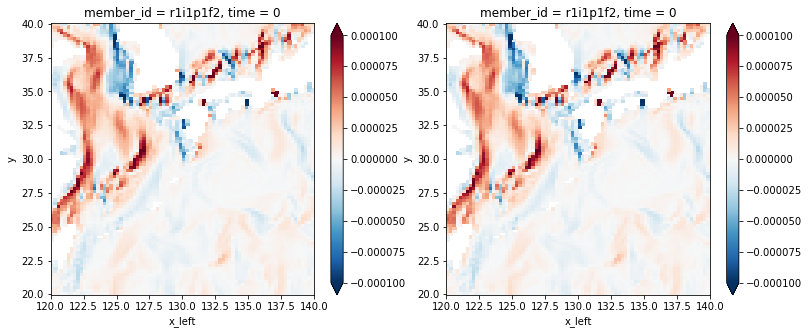

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=[13,5])
dt_dx.isel(time=0).sel(x_left=slice(120, 140), y=slice(20,40)).plot(ax=ax1, vmax=1e-4)
dt_dx_auto.isel(time=0).sel(x_left=slice(120, 140), y=slice(20,40)).plot(ax=ax2, vmax=1e-4)

The results are identical, and the user does not have to remember the names of the distance coordinates, `xgcm` takes care of it. The derivative in the y-direction can be calculated similarly.

Then, let's compute the full gradient amplitude for **all** the models in one loop, averaging the values over all members and 5 years at the beginning of the historical period.

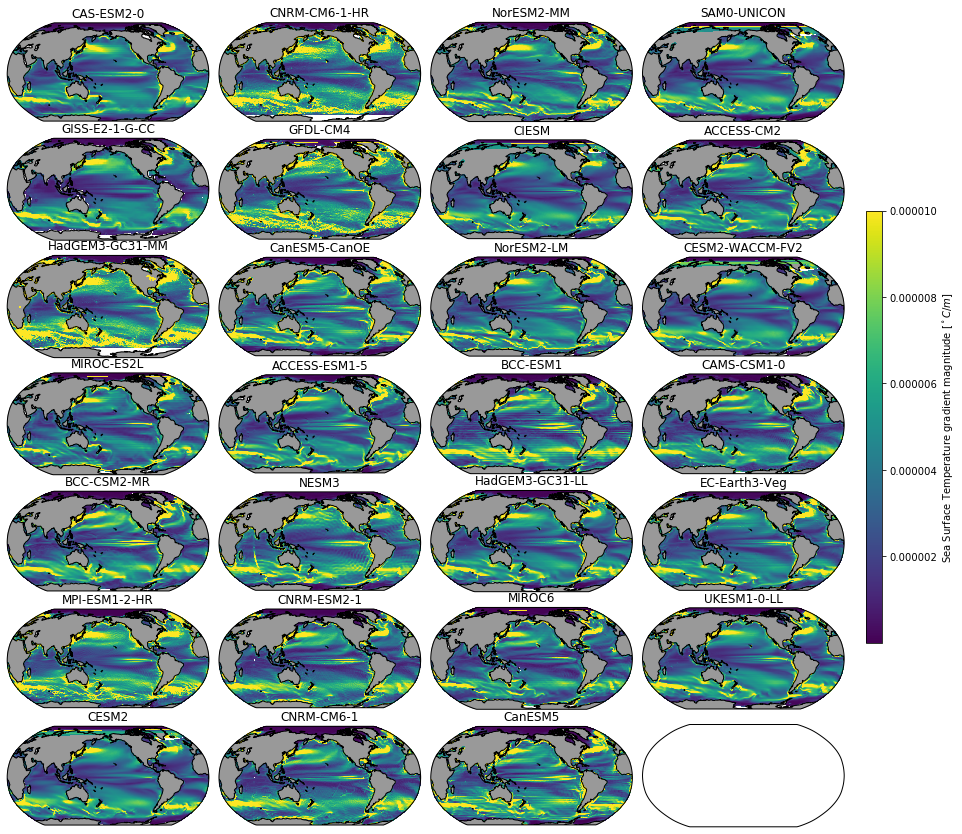

In [22]:
fig, axarr = plt.subplots(
    ncols=4, nrows=7, figsize=[15, 15], subplot_kw={"projection": ccrs.Robinson(190)}
)
for ax, (k, ds) in zip(axarr.flat, ddict_pp.items()):
    
    # the cmip6_preprocessing magic: 
    # create an xgcm grid object and dataset with reconstructed grid metrics
    grid, ds = combine_staggered_grid(ds, recalculate_metrics=True)
    
    da = ds.tos

    # some models have large values instead of nans, so we mask unresonable values
    da = da.where(da < 1e30)

    # calculate the zonal temperature gradient
    dt_dx = grid.derivative(da, 'X')
    dt_dy = grid.derivative(da, 'Y', boundary='extend')
    # these values are now situated on the cell faces, we need to 
    # interpolate them back to the center to combine them

    dt_dx = grid.interp(dt_dx, 'X')
    dt_dy = grid.interp(dt_dy, 'Y', boundary='extend')
    grad = (dt_dx**2 + dt_dy**2)**0.5

    ds['grad'] = grad

    # take an average over the first 5 years of the run
    ds = ds.isel(time=slice(0,12*5)).mean('time', keep_attrs=True)

    # take the average over all available model members
    if "member_id" in ds.dims:
        ds = ds.mean('member_id', keep_attrs=True)

    # and plot the resulting 2d array using xarray
    pp = ds.grad.plot(
        ax=ax,
        x="lon",
        y="lat",
        vmin=1e-9,
        vmax=1e-5,
        transform=ccrs.PlateCarree(),
        infer_intervals=False,
        add_colorbar=False,
    )
    ax.set_title(ds.attrs['source_id'])
    ax.add_feature(cfeature.LAND, facecolor='0.6')
    ax.coastlines()
    
fig.subplots_adjust(hspace=0.05, wspace=0.05)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])
fig.colorbar(pp, cax=cbar_ax, label="Sea Surface Temperature gradient magnitude [$^\circ C/m$]")

Not bad for five additional lines of code! 

Features like the western boundary currents and the fronts across along the Antarctic Circumpolar Current and the equatorial upwelling zones are clearly visible and present in most models.

## Calculate surface vorticity in the North Atlantic

But this was still just operating on a tracer field. What about velocity fields? We can also combine different variables into an xgcm compatible dataset!

The recommended workflow is to first load datasets seperately for each desired variable:

In [23]:
variables = ['thetao', 'uo', 'vo']
ddict_multi = {var:{} for var in variables}
for var in variables:
    cat_var = col.search(table_id='Omon',
                         grid_label='gn',
                         experiment_id='historical',
                         variable_id=var,
                         source_id=models)

    ddict_multi[var] = cat_var.to_dataset_dict(
        zarr_kwargs={'consolidated':True, 'decode_times':False},
        preprocess=combined_preprocessing
    )


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC6: No units found
MIROC-ES2L: No units found
CESM2-WACCM-FV2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`


CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC-ES2L: No units found
MIROC6: No units found
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC-ES2L: No units found
MIROC6: No units found
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC6: No units found
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC6: No units found
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 C

CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC6: No units foundMIROC-ES2L: No units found

CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC-ES2L: No units found
MIROC6: No units found
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC6: No units found
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC6: No units found
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC6: No units found
CESM2: Unexpected unit (centimeters) for coordin

CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC-ES2L: No units found
MIROC6: No units found
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC-ES2L: No units found
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC6: No units found
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC6: No units found
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC6: No units found
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC6: No units found
CESM2: Unexpected unit (centimeters) for coordin

Now we need to make sure to choose only the intersection between the keys of each sub-dictionary, because we need all 3 variables for each model.

In [24]:
ddict_multi_clean = {var:{} for var in variables}
for k in ddict_multi['thetao']:
    if all([k in ddict_multi[var] for var in variables]) and 'lev' in ddict_multi['thetao'][k].dims:
        for var in variables:
            ddict_multi_clean[var][k] = ddict_multi[var][k]

And now similar as before we can create a complete grid dataset, but we can pass additional datasets to be combined using the `other_ds` argument.  This can be a list of different variables, `cmip6_preprocessing` automatically detects the appropriate grid position.

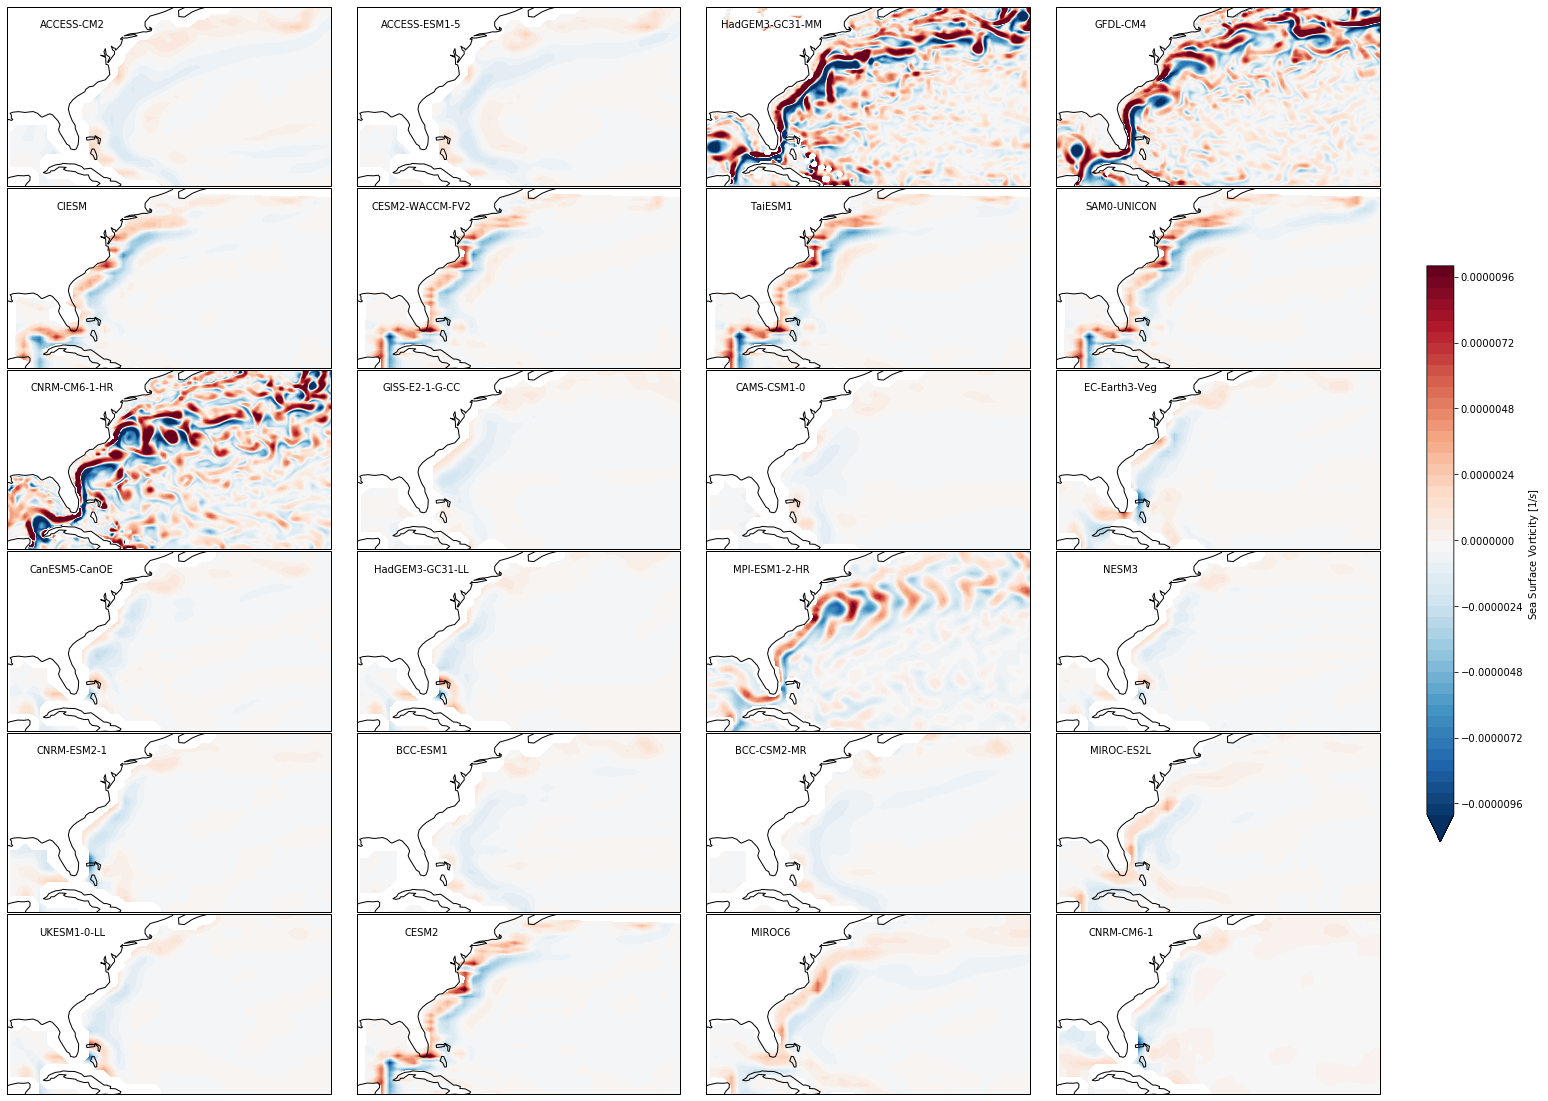

In [25]:
import matplotlib.path as mpath
import numpy as np
from xgcm import Grid
import xarray as xr

fig, axarr = plt.subplots(
    ncols=4, nrows=6, figsize=[25, 20], subplot_kw={"projection": ccrs.PlateCarree()}
)
for ai ,(ax, k) in enumerate(zip(axarr.flat, ddict_multi_clean['thetao'].keys())):
    ds_t = ddict_multi_clean['thetao'][k] # One tracer should always be the reference dataset!
    ds_u = ddict_multi_clean['uo'][k]
    ds_v = ddict_multi_clean['vo'][k]

    if 'lev' in ds_t: # show only models with depth coordinates in the vertical
        # aling only the intersection of the member_ids
        ds_t, ds_u, ds_v = xr.align(ds_t, ds_u, ds_v, join='inner', exclude=[di for di in ds_t.dims if di != 'member_id'])

        # combine all datasets and create grid with metrics
        grid, ds = combine_staggered_grid(ds_t, other_ds=[ds_u, ds_v], recalculate_metrics=True)


        # interpolate grid metrics at the corner points (these are not *yet* constructed by cmip6_preprocessing)
        ds.coords['dx_temp'] = grid.interp(ds['dx_gx'], 'Y', boundary='extend')
        ds.coords['dy_temp'] = grid.interp(ds['dy_gy'], 'X')
        
        ds = ds.chunk({'x':360})
        
        # selecting the surface value
        ds = ds.isel(lev=0)
        
        # For demonstration purposes select the first member and a single monthly timestep
        ds = ds.isel(time=10)
        
        if "member_id" in ds.dims:
            ds = ds.isel(member_id=0)

        grid = Grid(ds, periodic=['X'], metrics={'X':[co for co in ds.coords if 'dx' in co],
                                                'Y':[co for co in ds.coords if 'dy' in co]})


        dv_dx = grid.derivative(ds.vo, 'X')
        du_dy = grid.derivative(ds.uo, 'Y',boundary='extend')

        # check the position of the derivatives and interpolate back to tracer point for plotting
        if any(['x_' in di for di in dv_dx.dims]):
            dv_dx = grid.interp(dv_dx, 'X')
        if any(['y_' in di for di in dv_dx.dims]):
            dv_dx = grid.interp(dv_dx, 'Y', boundary='extend')

        if any(['x_' in di for di in du_dy.dims]):
            du_dy = grid.interp(du_dy, 'X')
        if any(['y_' in di for di in du_dy.dims]):
            du_dy = grid.interp(du_dy, 'Y', boundary='extend')

        curl = dv_dx - du_dy

        ds['curl'] = curl
        
        # Select the North Atlantic
        ds = ds.sel(x=slice(270,335), y=slice(10,55))

        # and plot the resulting 2d array using xarray
        pp = ds.curl.plot.contourf(
            levels=51,
            ax=ax,
            x="lon",
            y="lat",
            vmax=1e-5,
            transform=ccrs.PlateCarree(),
            infer_intervals=False,
            add_colorbar=False,
            add_labels=False
        )
        ax.text(0.2,0.9,ds.attrs['source_id'],horizontalalignment='center',verticalalignment='center',
                transform=ax.transAxes, fontsize=10)
        ax.coastlines()
        ax.set_extent([-90, -45, 20, 45], ccrs.PlateCarree())
fig.subplots_adjust(wspace=0.01, hspace=0.01)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])
fig.colorbar(pp, cax=cbar_ax, label="Sea Surface Vorticity [$1/s$]")

## A caveat: Reconstructed metrics

For all the examples shown here, we have relied on a simplified reconstruction of the grid metrics (in this case, the distances between different points on the grid). We can check the quality of the reconstruction indirectly by comparing these to the only horizontal grid metric that is saved with the ocean model output: The horizontal grid cell area.

We reconstruct our area naively as the product of the x and y distances centered on the tracer cell, `dx_t`, and `dy_t`.

In [26]:
ds = ddict_multi_clean['thetao']['CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gn']
_,ds = combine_staggered_grid(ds, recalculate_metrics=True)
area_reconstructed = ds.dx_t * ds.dy_t

Now lets load the actual area and compare the two.

In [27]:
url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)
cat = col.search(table_id='Ofx', variable_id='areacello', source_id='GFDL-CM4' , grid_label='gn') # switch to `grid_label='gr'` for regridded file
ddict = cat.to_dataset_dict(zarr_kwargs={'consolidated':True}, preprocess=combined_preprocessing)
_,ds_area = ddict.popitem()
area = ds_area.areacello.isel(member_id=0).squeeze()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


Text(0.5, 1.0, 'difference in %')

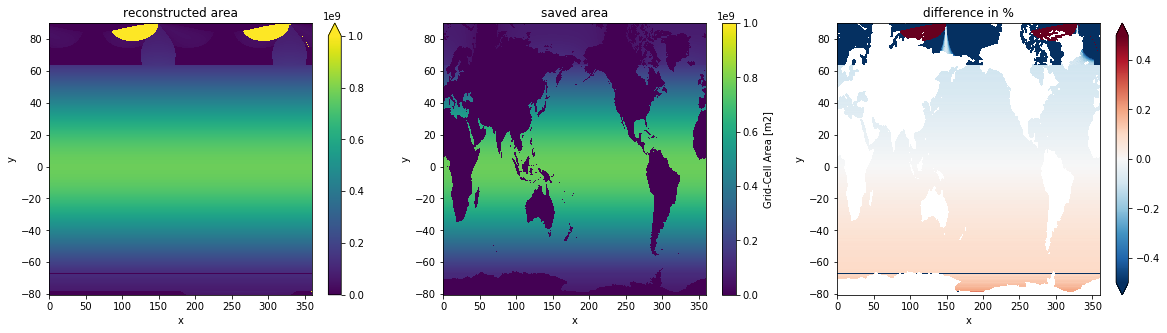

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=[20,5])
area_reconstructed.plot(ax=ax1, vmax=1e9)
area.plot(ax=ax2, vmax=1e9)
((area_reconstructed - area) / area * 100).plot(ax=ax3, vmax=0.5)
ax1.set_title('reconstructed area')
ax2.set_title('saved area')
ax3.set_title('difference in %')

You can see that for this particular model (`GFDL-CM4`), the reconstruction does reproduce the grid area with a less than 0.5% error between approximately 60S-60N. North of that, the grid geometry gets vastly more complicated, and the simple reconstruction fails. The area over which the reconstruction varies from model to model and as such caution should always be exercised when analyzing data using reconstructed metrics.

At this point, this is, however, the only way to run these kinds of analyses, since the original grid metrics are not routinely provided with the CMIP6 output. In order to truly reproduce analyses like e.g., budgets, the community requires the native model geometry.

## Conclusions

We show that using `cmip6_preprocessing` and `xgcm` users can analyze complex native ocean model grids without the need to interpolate data or keep track of the intricacies of single model grids. Using these tools already enables users to calculate common operators like the gradient and curl, [weighted averages](https://xgcm.readthedocs.io/en/latest/grid_metrics.html#Grid-aware-(weighted)-average) and more, in a 'grid-agnostic' way, with decent precision outside of the polar regions.

Pending on the availability of more grid metric output and building on these tools, complex analyses like various budgets could become a matter of a few lines and be calculated across all models in the CMIP6 archive. 

By combining generalizable and reproducible analysis with the [publicly available CMIP6 data](https://medium.com/pangeo/cmip6-in-the-cloud-five-ways-96b177abe396), more users will be able to analyze the data efficiently, leading to faster understanding and synthesis of the vast amount of data provided by modern climate modeling. 

### Acknowledgements
Julius Busecke's contributions to this work are motivated and developed as part of an ongoing project together with his postdoc advisor [Prof. Laure Resplandy](http://resplandy.princeton.edu/). This project investigates the influence of [equatorial dynamics on possible expansions of Oxygen Minimum Zones in the Pacific](https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2019GL082692) and is funded under the NOAA Cooperative Institute for Climate Science agreement NA14OAR4320106.